# Cargamos el modelo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import random
from sklearn.model_selection import train_test_split

input_dir = "/content/drive/MyDrive/Imagenes"
target_dir = "/content/drive/MyDrive/Masks"

#load input and segmented target image paths
input_image_path = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)])
target_path = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)])

In [3]:
assert len(input_image_path) == len(target_path)

In [4]:
def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

In [5]:
class_dict = {
    0: [0, 255, 255],  # Clase 0: Color amarillo
    1: [255, 255, 0],  # Clase 1: Color cyan
    2: [255, 0, 255],  # Clase 2: Color magenta
    3: [0, 255, 0],    # Clase 3: Color verde
    4: [0, 0, 255],    # Clase 4: Color azul
    5: [255, 255, 255]#,  # Clase 5: Color blanco
    #6: [0, 0, 0]        # Clase 6: Color negro
}

In [6]:
value_to_index = {tuple(v): k for k, v in class_dict.items()}
color_to_index = class_dict.keys()
index_to_value = class_dict.values()

In [7]:
def convert_target(target, value_to_index):
    """
    convert target segmentation map to [H, W, 1],
    where last channel is the index of the class.

    NOTE:
    We will later use sparse categorical cross entropy as loss

    """
    seg_map = np.zeros((target.shape[:2]), dtype="uint8")
    for val, id_ in value_to_index.items():
        seg_map[(target==list(val)).all(axis=2)] = id_
    return seg_map.reshape(target.shape[0], target.shape[1], 1)


def mask_to_rgb(mask, class_dict):
    """
    Convert a mask with class indices to an RGB image using the class_dict colors.
    """
    rgb_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_index, color in class_dict.items():
        rgb_image[mask == class_index] = color
    return rgb_image
def class_to_rgb(class_image, class_dict):
    """
    Convert a class image to an RGB image using the class_dict colors.

    Parameters:
    - class_image: numpy array of shape (H, W) or (H, W, 1) with class indices.
    - class_dict: dictionary mapping class indices to RGB colors.

    Returns:
    - rgb_image: numpy array of shape (H, W, 3) with RGB values.
    """
    # Remove the extra dimension if it exists
    if class_image.ndim == 3 and class_image.shape[2] == 1:
        class_image = class_image[:, :, 0]

    # Get the shape of the input image
    height, width = class_image.shape

    # Create an empty RGB image
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Fill the RGB image with the colors from the class_dict
    for class_index, color in class_dict.items():
        mask = (class_image == class_index)
        rgb_image[mask] = color

    return rgb_image


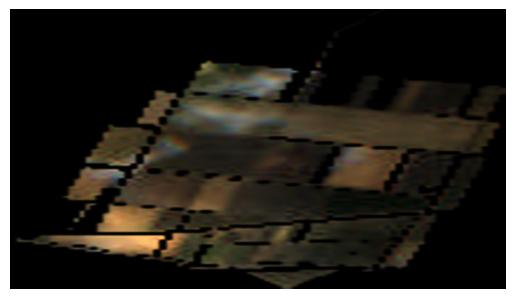

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils import load_img, img_to_array


plt.axis("off")
plt.imshow(load_img(input_image_path[19]))

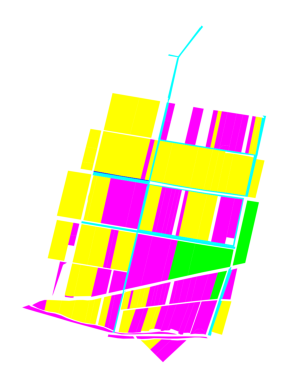

In [ ]:
tr = img_to_array(load_img(target_path[19]))
plt.imshow(tr.astype("uint8"), cmap='gray')
plt.axis("off")
plt.show()


In [9]:
img_size = (512,512)
num_images = len(input_image_path)

#shuffle
random.Random(12).shuffle(input_image_path)
random.Random(12).shuffle(target_path)

def get_img_from_path(path):
    return img_to_array(load_img(path, target_size=img_size))

def get_target_from_path(path):
    img = img_to_array(load_img(path, target_size=img_size,))
    img = convert_target(img.astype("uint8"), value_to_index)
    return img

input_images = np.zeros((num_images,) + img_size +(3,), dtype="float32")
targets = np.zeros((num_images,) + img_size +(1,), dtype="uint8")

for i in range(num_images):
    input_images[i] = get_img_from_path(input_image_path[i])/255.
    targets[i] = get_target_from_path(target_path[i])

In [10]:
#train-test-validation split

train_inputs, test_inputs, train_targets, test_targets = train_test_split( input_images, targets ,test_size=0.20, random_state=42)
valid_inputs, test_inputs, valid_targets, test_targets = train_test_split(test_inputs, test_targets ,test_size=0.50, random_state=42)



In [11]:
#Data loaders for train and validation data

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16


train_dataloader = tf.data.Dataset.from_tensor_slices((train_inputs, train_targets))
valid_dataloader = tf.data.Dataset.from_tensor_slices((valid_inputs, valid_targets))
test_dataloader = tf.data.Dataset.from_tensor_slices((test_inputs, test_targets))

trainloader = (
    train_dataloader
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validloader = (
    valid_dataloader
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [45]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.axis("off")
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img( display_list[i]))
    plt.axis('off')
    plt.show()




<ipython-input-21-3ef1d7635727>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, len(display_list), i+1)


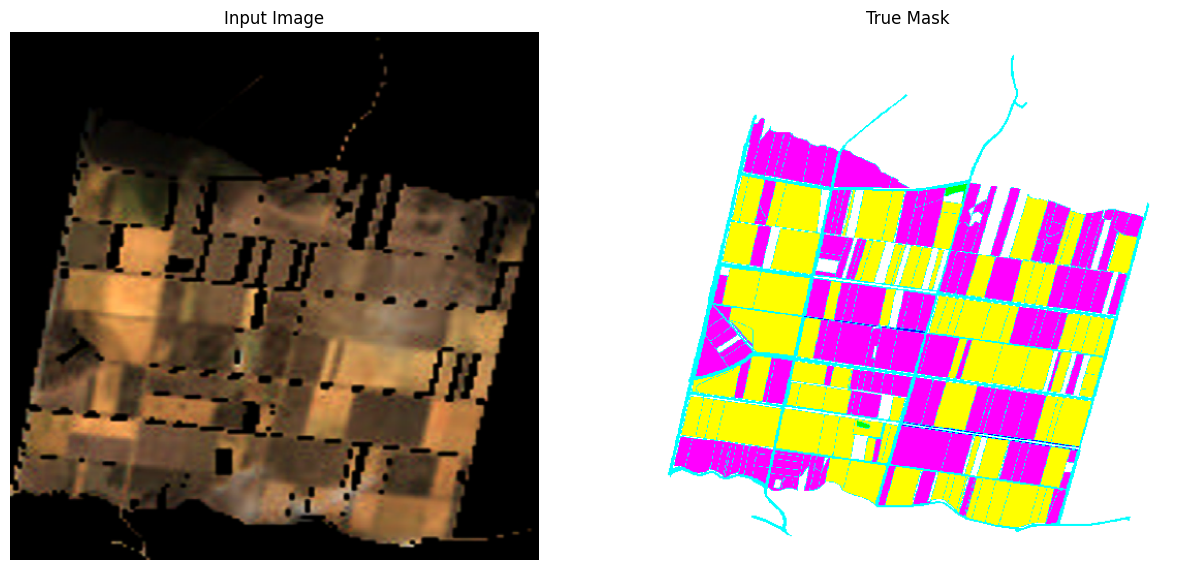

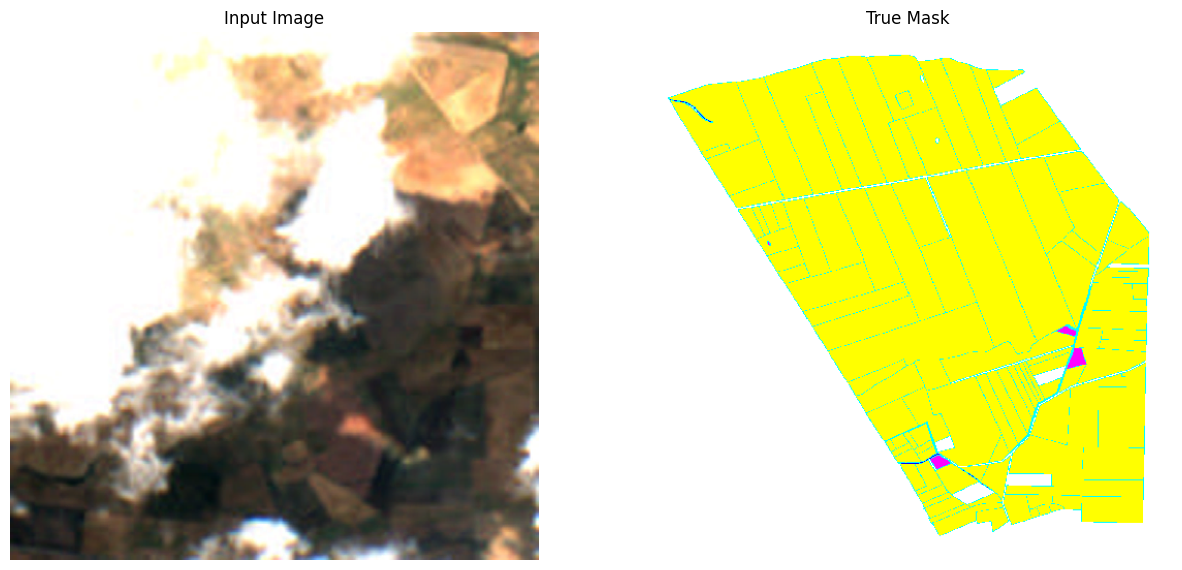

In [ ]:
for images, masks in trainloader.take(2):
    sample_image, sample_mask = images[0], masks[0]
    sample_RGB=class_to_rgb(sample_mask, class_dict)
    display([sample_image,sample_RGB])

In [12]:
from tensorflow import keras
from keras import layers

from keras import backend as K
import keras

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [13]:
def get_UNET(img_size, num_classes=6):

    #encoder
    inputs = keras.Input(shape=img_size +(3,))

    conv1_1 = layers.Conv2D(16 ,3, padding="same")(inputs)
    bn1_1 = layers.BatchNormalization()(conv1_1)
    bn1_1 = layers.LeakyReLU()(bn1_1)
    conv1_2 = layers.Conv2D(16 ,3, padding="same")(bn1_1)
    bn1_2 = layers.BatchNormalization()(conv1_2)
    bn1_2 = layers.LeakyReLU()(bn1_2)
    max_pool_1 = layers.MaxPooling2D((2, 2))(bn1_2)
    resedual1 = layers.Conv2D(32,1,padding="same")(max_pool_1)

    conv2_1 = layers.Conv2D(32 ,3, padding="same")(max_pool_1)
    bn2_1 = layers.BatchNormalization()(conv2_1)
    bn2_1 = layers.LeakyReLU()(bn2_1)
    conv2_2 = layers.Conv2D(32 ,3, padding="same")(bn2_1)
    bn2_2 = layers.BatchNormalization()(conv2_2)
    bn2_2 = layers.add([bn2_2, resedual1])
    bn2_2 = layers.LeakyReLU()(bn2_2)
    max_pool_2 = layers.MaxPooling2D((2, 2))(bn2_2)
    resedual2 = layers.Conv2D(64,1,padding="same")(max_pool_2)

    conv3_1 = layers.Conv2D(64 ,3, padding="same")(max_pool_2)
    bn3_1 = layers.BatchNormalization()(conv3_1)
    bn3_1 = layers.LeakyReLU()(bn3_1)
    conv3_2 = layers.Conv2D(64 ,3, padding="same")(bn3_1)
    bn3_2 = layers.BatchNormalization()(conv3_2)
    bn3_2 = layers.add([bn3_2, resedual2])
    bn3_2 = layers.LeakyReLU()(bn3_2)
    max_pool_3 = layers.MaxPooling2D((2, 2))(bn3_2)
    resedual3 = layers.Conv2D(128,1,padding="same")(max_pool_3)


    conv4_1 = layers.Conv2D(128 ,3, padding="same")(max_pool_3)
    bn4_1 = layers.BatchNormalization()(conv4_1)
    bn4_1 = layers.LeakyReLU()(bn4_1)
    conv4_2 = layers.Conv2D(128 ,3, padding="same")(bn4_1)
    bn4_2 = layers.BatchNormalization()(conv4_2)
    bn4_2 = layers.add([bn4_2, resedual3])
    bn4_2 = layers.LeakyReLU()(bn4_2)
    conv4_3 = layers.Conv2D(128 ,3, padding="same")(bn4_2)
    bn4_3 = layers.BatchNormalization()(conv4_3)
    bn4_3 = layers.LeakyReLU()(bn4_3)

    conv5_1 = layers.Conv2D(64 ,3, padding="same")(bn4_3)
    bn5_1 = layers.BatchNormalization()(conv5_1)
    bn5_1 = layers.LeakyReLU()(bn5_1)
    conv5_2 = layers.Conv2D(64 ,3, padding="same")(bn5_1)
    bn5_2 = layers.BatchNormalization()(conv5_2)
    bn5_2 = layers.LeakyReLU()(bn5_2)
    conv5_3 = layers.Conv2D(64 ,3, padding="same")(bn5_2)
    bn5_3 = layers.BatchNormalization()(conv5_3)
    bn5_3 = layers.LeakyReLU()(bn5_3)
    resedual5 = layers.Conv2DTranspose(32, 2, strides=(2,2), padding="same")(bn5_3)
    resedual5 = layers.Conv2D(32, 1, padding="same")(resedual5)

    #decoder

    conv6_up = layers.Conv2DTranspose(32, 3, strides = (2, 2), padding = 'same')(bn5_3)
    conv6_up = layers.BatchNormalization()(conv6_up)
    conv6_up = layers.add([conv6_up, resedual5])
    conv6_up = layers.concatenate([conv6_up, bn3_2])
    conv6_up = layers.LeakyReLU()(conv6_up)
    conv6_1 = layers.Conv2D(32 ,3, padding="same")(conv6_up)
    bn6_1 = layers.BatchNormalization()(conv6_1)
    bn6_1 = layers.LeakyReLU()(bn6_1)
    conv6_2 = layers.Conv2D(32 ,3, padding="same")(bn6_1)
    bn6_2 = layers.BatchNormalization()(conv6_2)
    bn6_2 = layers.LeakyReLU()(bn6_2)
    resedual6 = layers.Conv2DTranspose(16, 2, strides=(2,2), padding="same")(bn6_2)
    resedual6 = layers.Conv2D(16, 1, padding="same")(resedual6)


    conv7_up = layers.Conv2DTranspose(16, 3, strides = (2, 2), padding = 'same')(bn6_2)
    conv7_up = layers.BatchNormalization()(conv7_up)
    conv7_up = layers.add([conv7_up, resedual6])
    conv7_up = layers.concatenate([conv7_up, bn2_2])
    conv7_up = layers.LeakyReLU()(conv7_up)
    conv7_1 = layers.Conv2D(16 ,3, padding="same")(conv7_up)
    bn7_1 = layers.BatchNormalization()(conv7_1)
    bn7_1 = layers.LeakyReLU()(bn7_1)
    conv7_2 = layers.Conv2D(16 ,3, padding="same")(bn7_1)
    bn7_2 = layers.BatchNormalization()(conv7_2)
    bn7_2 = layers.LeakyReLU()(bn7_2)
    resedual7 = layers.Conv2DTranspose(num_classes, 2, strides=(2,2), padding="same")(bn7_2)
    resedual7 = layers.Conv2D(num_classes, 1, padding="same")(resedual7)


    conv8_up = layers.Conv2DTranspose(num_classes, 3, strides = (2, 2), padding = 'same')(bn7_2)
    conv8_up = layers.BatchNormalization()(conv8_up)
    conv8_up = layers.add([conv8_up, resedual7])
    conv8_up = layers.concatenate([conv8_up, bn1_2])
    conv8_up = layers.LeakyReLU()(conv8_up)
    conv8_1 = layers.Conv2D(num_classes ,3, padding="same")(conv8_up)
    bn8_1 = layers.BatchNormalization()(conv8_1)
    bn8_1 = layers.LeakyReLU()(bn8_1)
    conv8_2 = layers.Conv2D(num_classes ,3, padding="same")(bn8_1)
    bn8_2 = layers.BatchNormalization()(conv8_2)
    bn8_2 = layers.LeakyReLU()(bn8_2)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(bn8_2)
    model = keras.Model(inputs, outputs)
    return model

In [14]:
model = get_UNET(img_size, num_classes=6)

In [30]:
def CE_dice_loss(y_true, y_pred, lamb1 = 0.2, lamb2= 0.8, gamma=1e-6):

    #CE =  tf.keras.losses.categorical_crossentropy(y_true, y_pred)


    y_true_dice = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=6))
    y_pred_dice = K.flatten(y_pred)

    CE =  tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    intersect = K.sum(y_true_dice * y_pred_dice, axis=-1)
    denom = K.sum(y_true_dice * y_true_dice, axis=-1) + K.sum(y_pred_dice * y_pred_dice, axis=-1)

    dice_loss = 1- K.mean((2. * intersect + gamma) / (denom + gamma))

    return lamb1*CE + lamb2*(dice_loss)

In [31]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('seg_weightsAccuracy.h5', verbose=1, save_best_only=True)
]

In [32]:
model.compile(optimizer='rmsprop', loss=CE_dice_loss, metrics=['accuracy'])
historyAccuracy = model.fit(trainloader, epochs=100, validation_data=validloader, callbacks=callbacks)

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.7556 - accuracy: 0.4459
Epoch 1: val_loss improved from inf to 0.95635, saving model to seg_weightsAccuracy.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 61s 1s/step - loss: 0.7556 - accuracy: 0.4459 - val_loss: 0.9563 - val_accuracy: 0.3237 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.6544
Epoch 2: val_loss did not improve from 0.95635
28/28 [==============================] - 18s 658ms/step - loss: 0.5231 - accuracy: 0.6544 - val_loss: 1.0569 - val_accuracy: 0.3231 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.4333 - accuracy: 0.6971
Epoch 3: val_loss did not improve from 0.95635
28/28 [==============================] - 19s 667ms/step - loss: 0.4333 - accuracy: 0.6971 - val_loss: 1.1257 - val_accuracy: 0.3231 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.7093
Epoch 4: val_loss did not improve from 0.95635
28/28 [==============================] - 19s 664ms/step - loss: 0.3974 - accuracy: 0.7093 - val_loss: 1.1570 - val_accuracy: 0.3231 - lr: 0.00

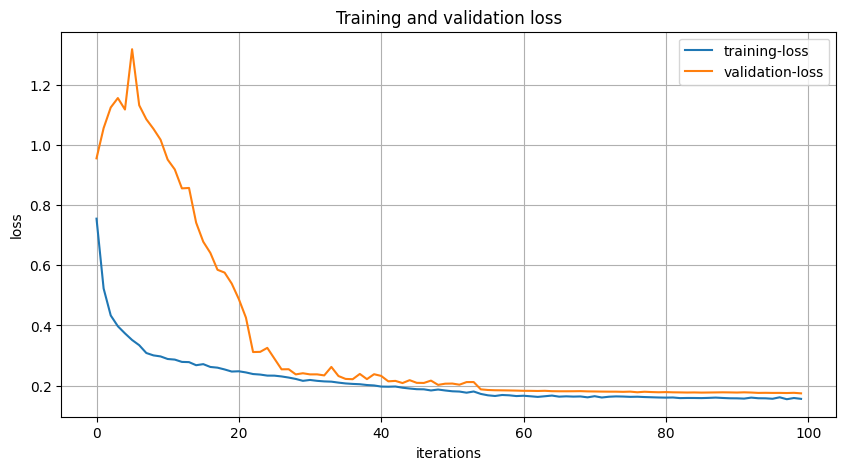

In [33]:
plt.figure(figsize=(10, 5))
training_history = historyAccuracy.history

plt.plot(range(len(training_history["loss"])), training_history["loss"], label="training-loss")
plt.plot(range(len(training_history["loss"])), training_history["val_loss"], label="validation-loss")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.title("Training and validation loss")
plt.show()

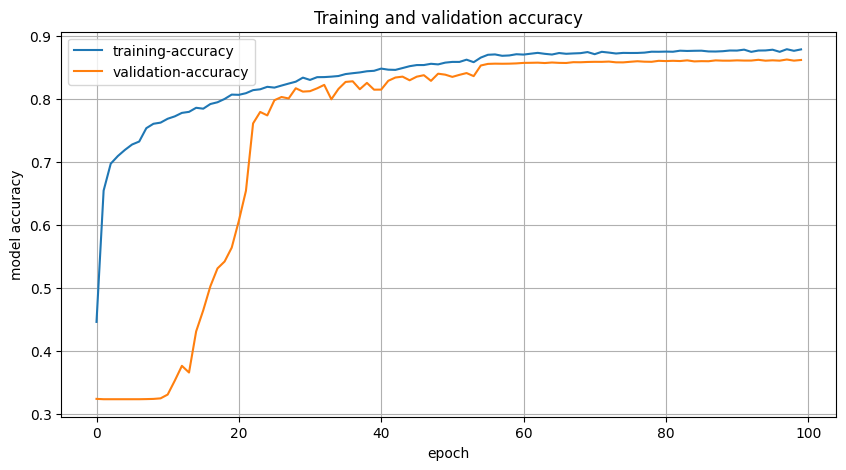

In [35]:
plt.figure(figsize=(10, 5))
training_history = historyAccuracy.history

plt.plot(range(len(training_history["accuracy"])), training_history["accuracy"], label="training-accuracy")
plt.plot(range(len(training_history["accuracy"])), training_history["val_accuracy"], label="validation-accuracy")
plt.xlabel("epoch")
plt.ylabel("model accuracy")
plt.legend()
plt.grid()
plt.title("Training and validation accuracy")
plt.show()


In [36]:
loaded_model = keras.models.load_model("seg_weightsAccuracy.h5", custom_objects={"CE_dice_loss":CE_dice_loss})
preds = np.argmax(loaded_model.predict(test_inputs), axis=-1)

2/2 [==============================] - 27s 11s/step


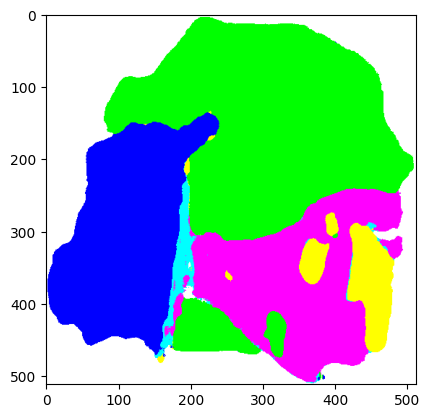

In [ ]:
#preds_color=convert_to_target(preds[0],class_dict)

preds_color=mask_to_rgb(preds[0], class_dict)
plt.imshow(preds_color)

<ipython-input-45-3ef1d7635727>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, len(display_list), i+1)


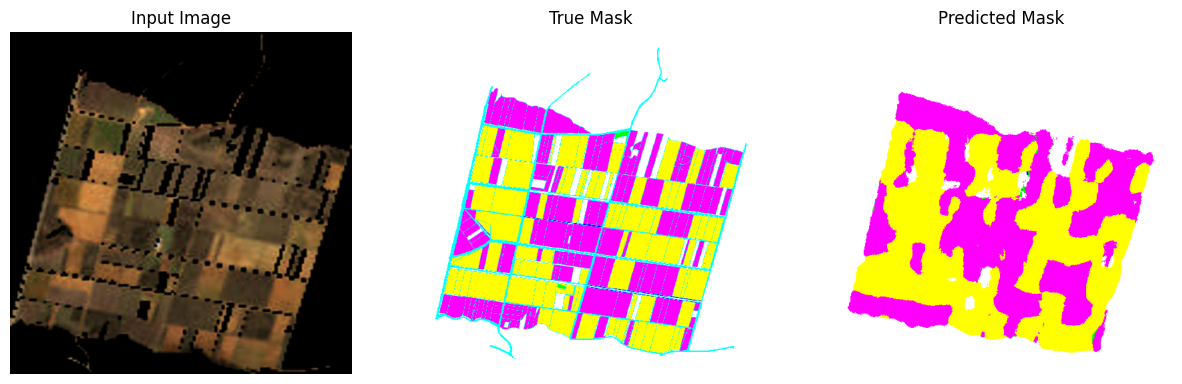

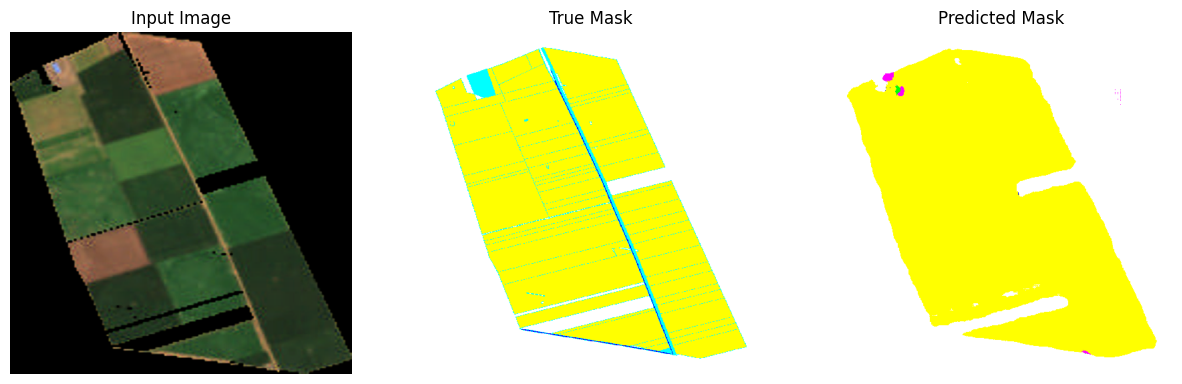

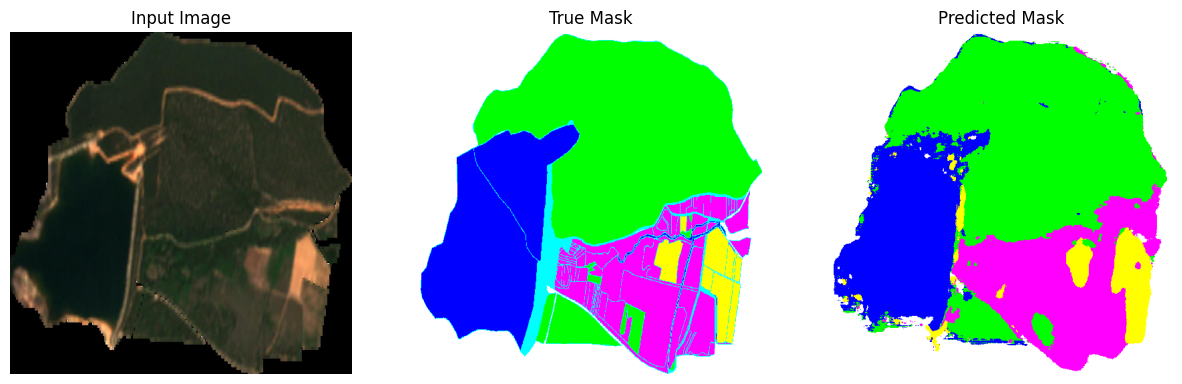

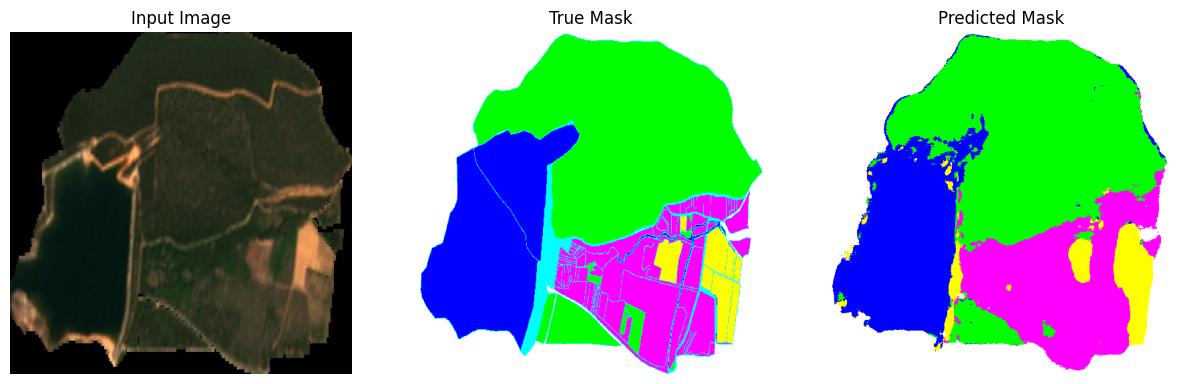

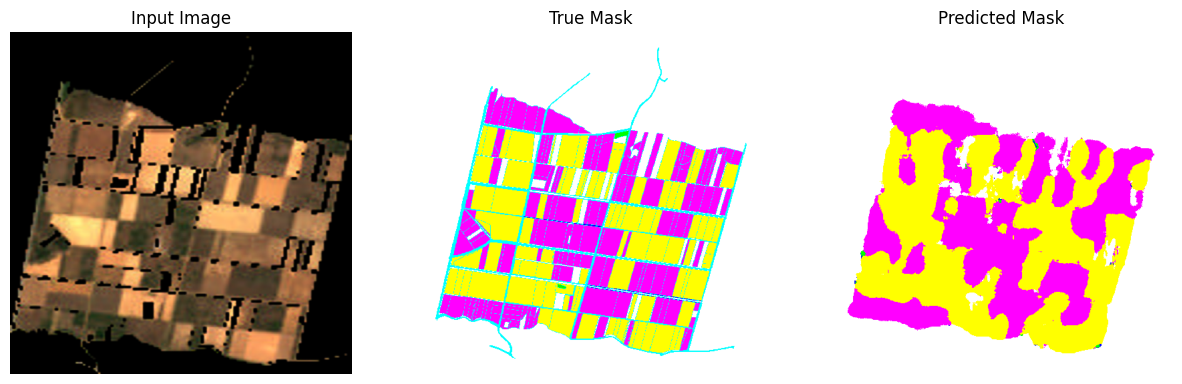

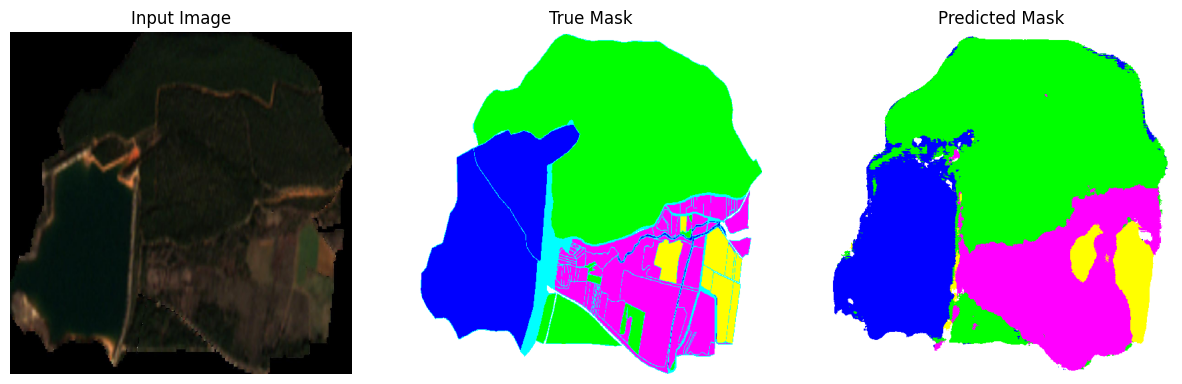

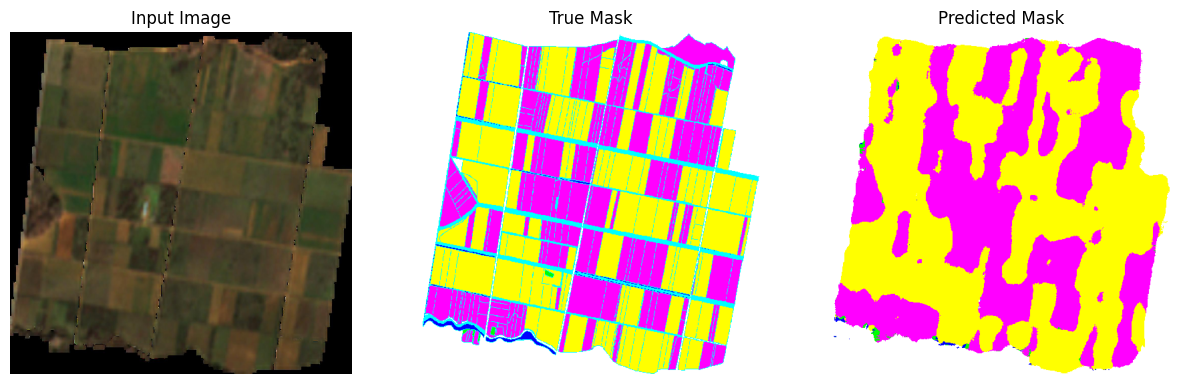

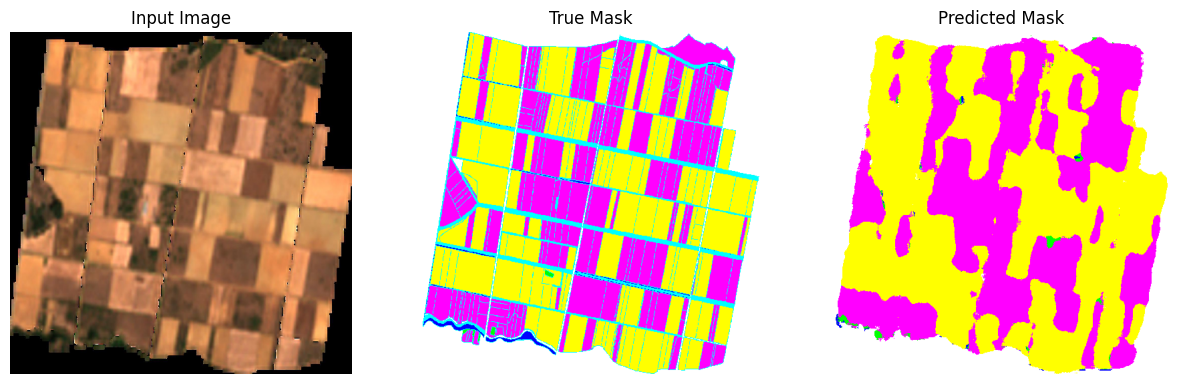

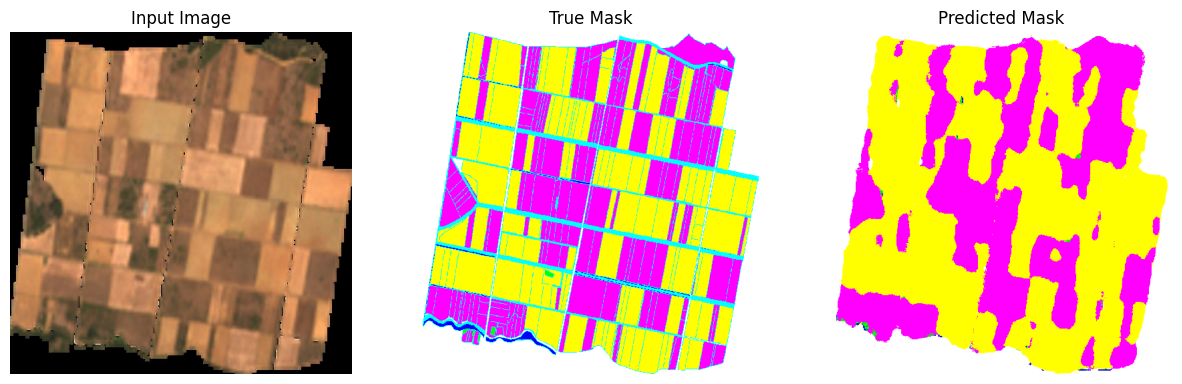

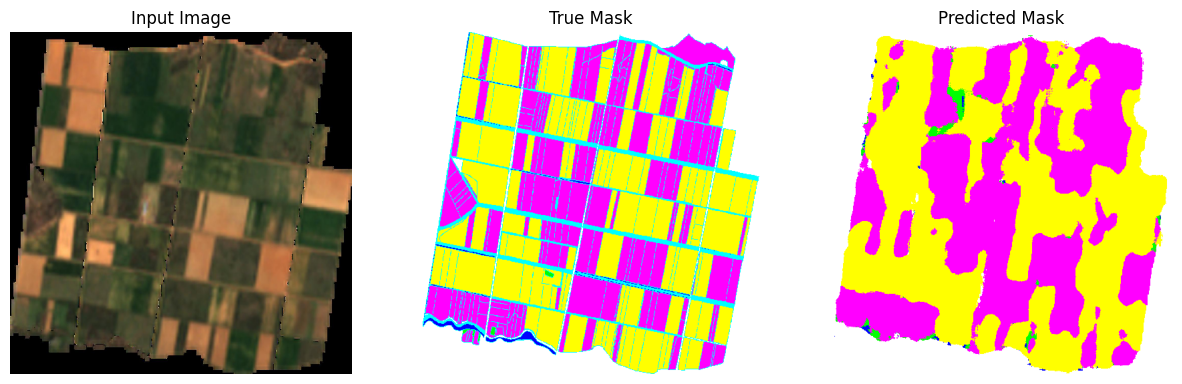

In [46]:
for i in range(10,20):
    preds_color=class_to_rgb(preds[i],class_dict)
    tests_color=class_to_rgb(test_targets[i],class_dict)
    display([test_inputs[i], tests_color,preds_color])

In [48]:
def IoU_metric(y_true, y_pred):
    num_classes = y_pred.shape[-1]
    y_true = y_true.reshape((y_true.shape[0], y_true.shape[1], y_true.shape[2]))
    y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
    y_true = np.array([ y_true == i for i in range(num_classes) ]).transpose(1,2,3,0)

    intersection = np.sum(np.logical_and(y_pred, y_true), axis=(1, 2))
    union = np.sum(np.logical_or(y_pred, y_true), axis=(1, 2))

    smooth = 1e-4
    iou = (intersection + smooth) / (union + smooth)
    return np.mean(iou)

def Dice_coeff(y_true, y_pred):
    num_classes = y_pred.shape[-1]
    y_true = y_true.reshape((y_true.shape[0], y_true.shape[1], y_true.shape[2]))
    y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0).astype("uint8")
    y_true = np.array([ y_true == i for i in range(num_classes) ]).transpose(1,2,3,0).astype("uint8")

    smooth = 1e-4
    numerator = np.sum(np.abs(y_pred * y_true), axis=(1, 2))
    denominator = np.sum(np.abs(y_true), axis=(1, 2)) + np.sum(np.abs(y_pred), axis=(1, 2))
    dice = (2 * (numerator) + smooth)/(denominator + smooth)

    return np.mean(dice)


In [40]:
sfmax_predictions = loaded_model.predict(test_inputs)

2/2 [==============================] - 1s 413ms/step


In [54]:
mean_iou = IoU_metric(test_targets, sfmax_predictions)
mean_dice = Dice_coeff(test_targets, sfmax_predictions)

print(mean_iou, mean_dice)

0.43718051447289374 0.4822359358289289


[0.9671880225703259, 0.8780234037216161, 0.8854913273922482, 0.9568213603001294, 0.967814430749878, 0.8521739921181449, 0.9565777470471793, 0.9652369933208799, 0.9536536246770188, 0.9063059610133359, 0.892422154521327, 0.9676900316708005, 0.8967669544343142, 0.9071590133788278, 0.8794356748939012, 0.8882003609489494, 0.7975190353451665, 0.8034348563665911, 0.8065262068199391, 0.7877524773515736, 0.8844680890931362, 0.9038287349920254, 0.8762614428556308, 0.8910499048585925, 0.9048574017101274, 0.8041465433027303, 0.9667116025005796, 0.9058940163068281, 0.8791737426230178, 0.9700720711923526, 0.5624544614170021, 0.9376773534560476, 0.7641242916769833, 0.8575438097182766, 0.8790028389774828, 0.9699626123654611, 0.900752309294701, 0.9624538300160606, 0.9496648213193319, 0.9570109403546482, 0.9101586952429168, 0.89555216265589, 0.8543775278452189, 0.9452362079060542, 0.7811338882085578, 0.9198201064276526, 0.9094531960459133, 0.9527924230485673, 0.9586788814562321, 0.7909144182660912, 0.95

<ipython-input-45-3ef1d7635727>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, len(display_list), i+1)


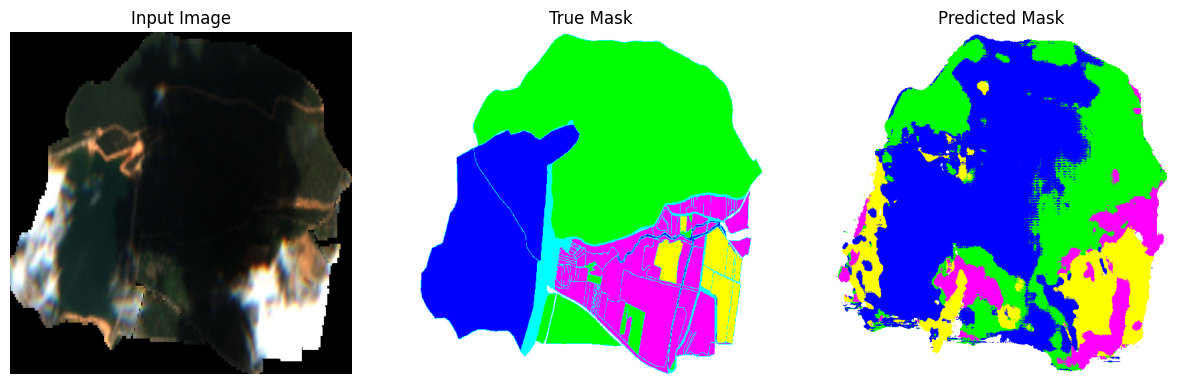

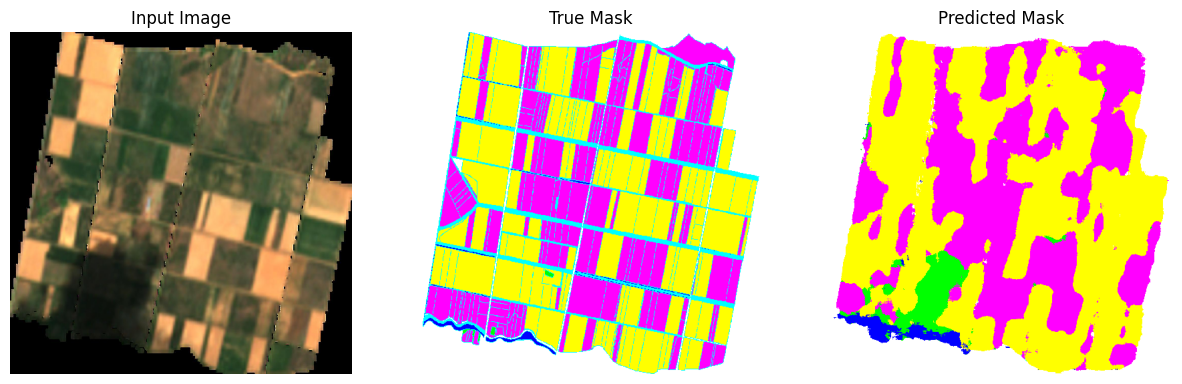

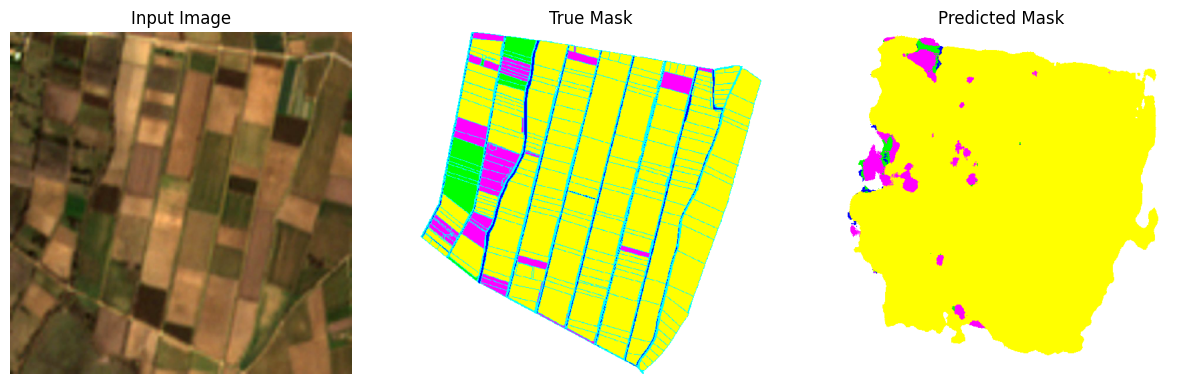

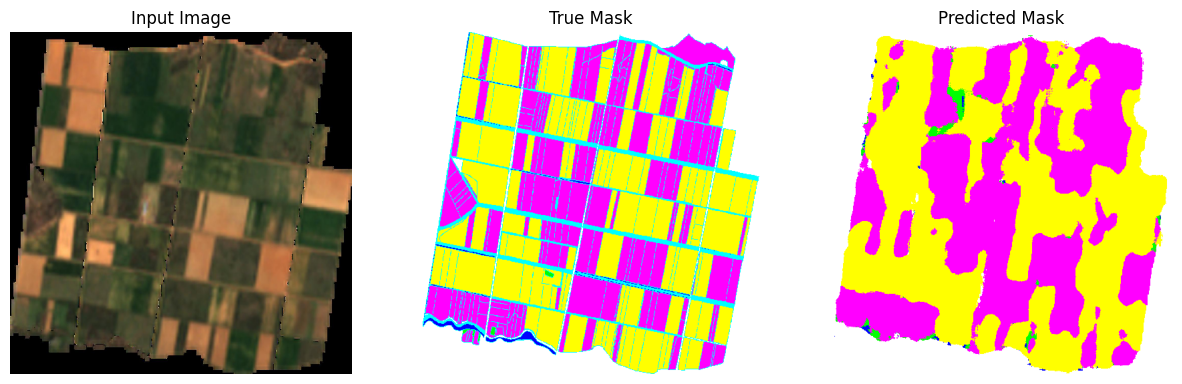

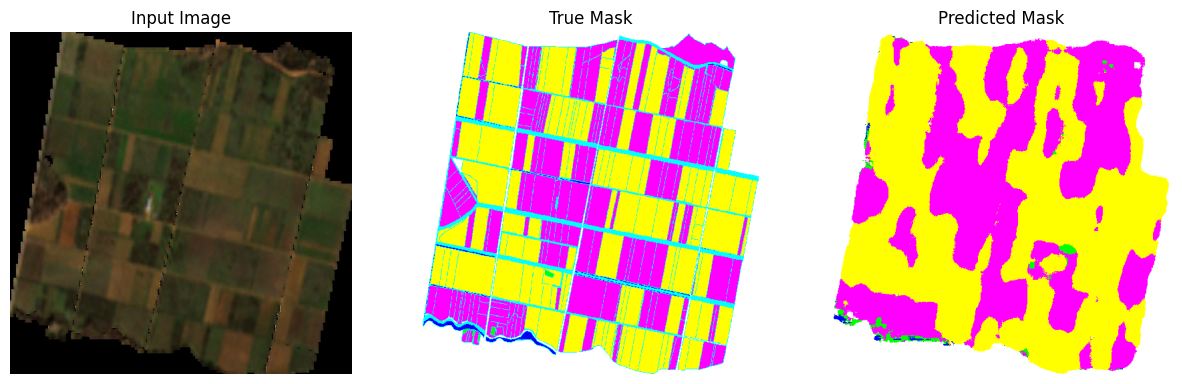

Peores imágenes en términos de coeficiente Dice:


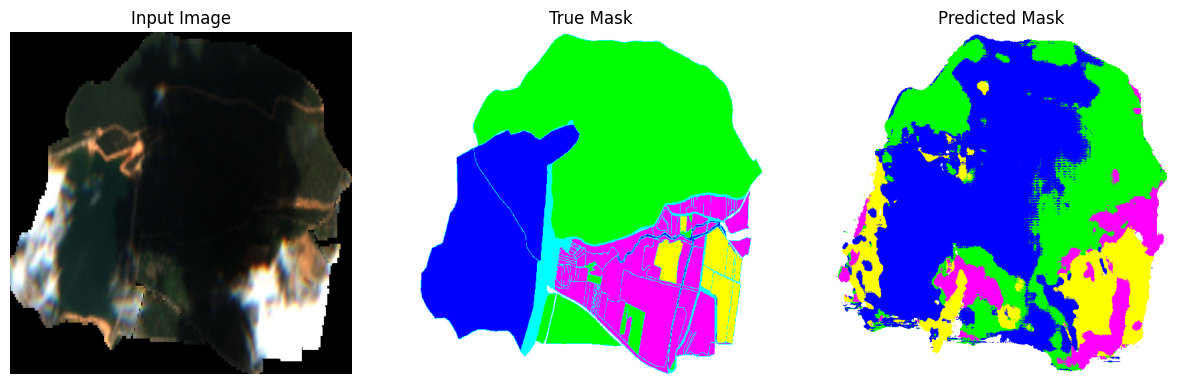

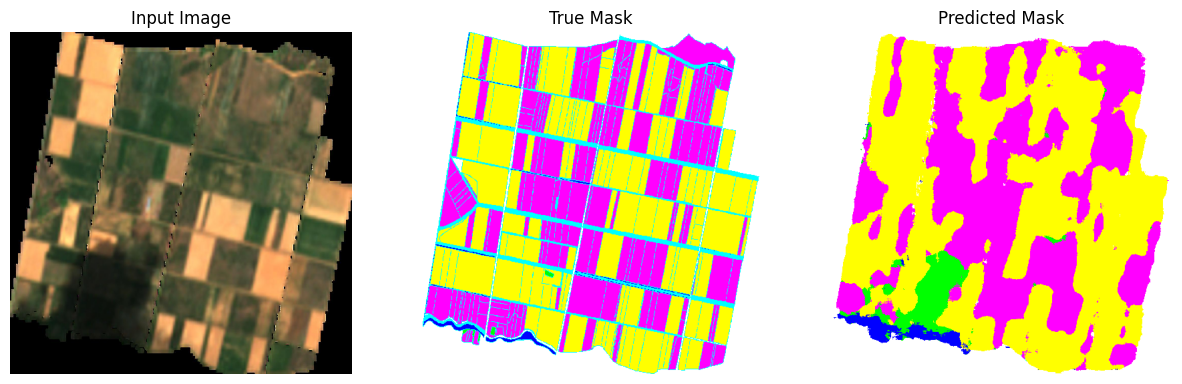

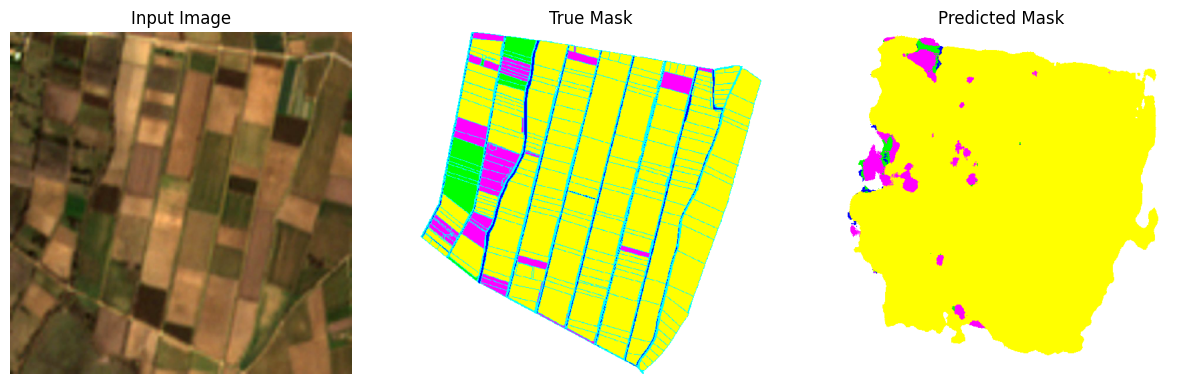

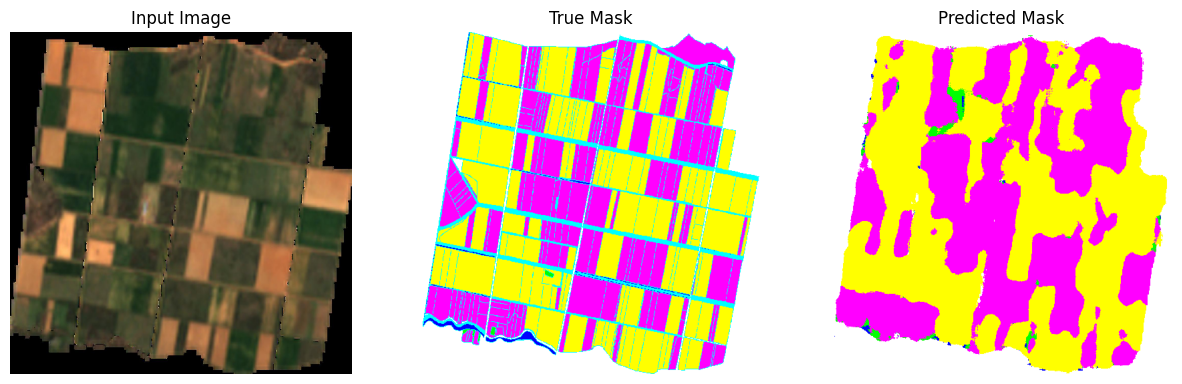

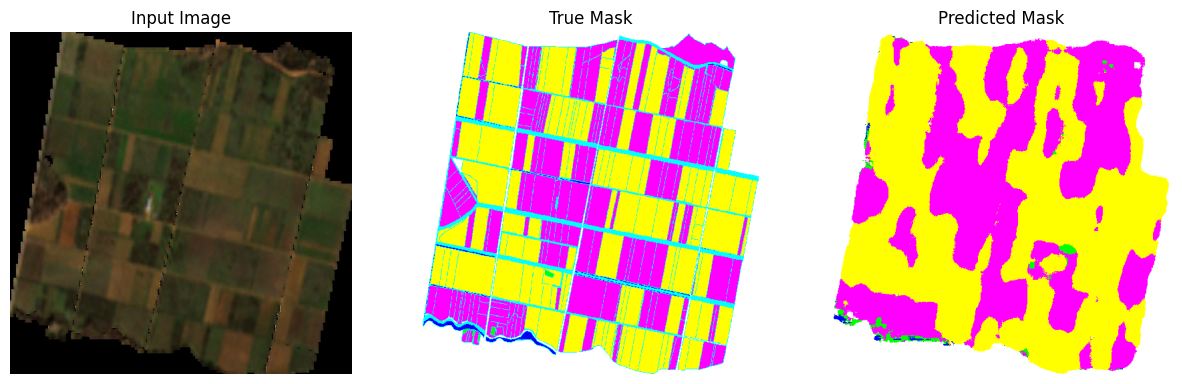

peores dice
Imagen 30 - IoU: 0.7199626936905001
Imagen 32 - IoU: 0.8662930330611286
Imagen 44 - IoU: 0.8771197868630831
Imagen 19 - IoU: 0.8812768963513045
Imagen 49 - IoU: 0.8832520529068414


In [55]:
def IoU_metric1(y_true, y_pred):
    num_classes = y_pred.shape[-1]
    y_true = y_true.reshape((y_true.shape[0], y_true.shape[1], y_true.shape[2]))
    y_pred = np.argmax(y_pred, axis=-1)


    for i in range(len(y_true)):
        intersection = np.sum((y_pred[i] & y_true[i]).astype(float))
        union = np.sum((y_pred[i] | y_true[i]).astype(float))
        smooth = 1e-4
        iou = (intersection + smooth) / (union + smooth)
        iou_scores.append(iou)

def Dice_coeff1(y_true, y_pred):
    num_classes = y_pred.shape[-1]
    y_true = y_true.reshape((y_true.shape[0], y_true.shape[1], y_true.shape[2]))
    y_pred = np.argmax(y_pred, axis=-1)


    for i in range(len(y_true)):
        smooth = 1e-4
        intersection = np.sum((y_pred[i] & y_true[i]).astype(float))
        denominator = np.sum(y_pred[i].astype(float)) + np.sum(y_true[i].astype(float))
        dice = (2 * intersection + smooth) / (denominator + smooth)
        dice_scores.append(dice)

# Calcular las métricas para cada imagen
iou_scores = []
dice_scores = []

IoU_metric1(test_targets, sfmax_predictions)
Dice_coeff1(test_targets, sfmax_predictions)

print(iou_scores)

#Obtener los índices de las imágenes con los peores resultados
num_images_to_show = 5
worst_iou_indices = np.argsort(iou_scores)[:num_images_to_show]
worst_dice_indices = np.argsort(dice_scores)[:num_images_to_show]

print("peores iou")
for index in worst_iou_indices:
    print("Imagen {} - IoU: {}".format(index, iou_scores[index]))


# Mostrar las imágenes con los peores resultados
print("Peores imágenes en términos de IoU:")
for index in worst_iou_indices:
    preds_color=class_to_rgb(preds[index],class_dict)
    tests_color=class_to_rgb(test_targets[index],class_dict)
    display([test_inputs[index], tests_color, preds_color])

print("Peores imágenes en términos de coeficiente Dice:")
for index in worst_dice_indices:
    preds_color=class_to_rgb(preds[index],class_dict)
    tests_color=class_to_rgb(test_targets[index],class_dict)
    display([test_inputs[index], tests_color, preds_color])

print("peores dice")
for index in worst_dice_indices:
    print("Imagen {} - DICE: {}".format(index, dice_scores[index]))



In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Leer el GeoDataFrame
ruta = '/content/drive/MyDrive/TFG_PabloNatal/Recinto1/polygons.shp'
geodf = gpd.read_file(ruta)

# Cambiar a coordenadas GPS lon/lat
geodf = geodf.to_crs("EPSG:4326")  # WGS84

# Cargar la imagen de fondo (512x512)
background_img = prediction

# Definir los límites de la imagen
extent = [geodf.bounds.minx.min(), geodf.bounds.maxx.max(), geodf.bounds.miny.min(), geodf.bounds.maxy.max()]

# Crear subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot para la imagen de fondo y límites del polígono
axs[0].imshow(background_img, extent=extent)
geodf.boundary.plot(ax=axs[0], color='red')
axs[0].set_title('Prediction con boundaries')

# Subplot para la otra imagen
axs[1].imshow(imagen_adicional_redimensionada)
axs[1].set_title('Mascara real')

plt.show()
